# Project 7_Kaiyue Wu

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm
import scipy.stats

new_line = '\n'
pd.options.mode.chained_assignment = None 
import warnings
warnings.filterwarnings('ignore')

sns.set(font_scale=1.5, rc={'text.usetex' : True,})
%config InlineBackend.figure_format='retina'

## 1

In [2]:
r = 0.04
dt = 0.002
K =10
sigma = 0.2
T = 0.5
S0 = np.arange(4,17,1)
dx1 = sigma*np.sqrt(dt)
dx2 = sigma*np.sqrt(3*dt)
dx3 = sigma*np.sqrt(4*dt)
dX = sigma*np.array([np.sqrt(dt),np.sqrt(3*dt),np.sqrt(4*dt)])

In [3]:
#Black Scholes prices
def BS(S0,K,sigma,r,T,option_type):
    d1 = (np.log(S0/K)+(r+0.5*sigma**2)*T)/(sigma * np.sqrt(T))
    d2 = d1-np.sqrt(T)*sigma
    
    if option_type.lower() == 'call':
        price  = (S0*scipy.stats.norm.cdf(d1,0.0,1.0)-K*np.exp(-r*T)*scipy.stats.norm.cdf(d2,0.0,1.0))
    else:
        price  = (K*np.exp(-r*T)*scipy.stats.norm.cdf(-d2, 0.0, 1.0)-S0*scipy.stats.norm.cdf(-d1,0.0,1.0))
    
    return price
#BS(S0=S0[0],K=K,sigma=sigma,r=r,T=T,option_type='put')

In [4]:
# Pu = dt*(sigma**2/(2*dx1**2)+(r-sigma**2/2)/(2*dx1))
# Pm = 1 - dt*sigma**2/(dx1**2) - r*dt
# Pd = dt*(sigma**2/(2*dx1**2)-(r-sigma**2/2)/(2*dx1))
# steps = int(T/dt)
# gridPrice = np.arange(np.log(16)+dx1,np.log(4)-dx1,-dx1)
# index = np.where(np.exp(gridPrice)<S0[0])[0][0]
# N = len(gridPrice)
# A = np.zeros((N,N))
# pmtx = [Pu,Pm,Pd]
# A[0,[0,1,2]] = pmtx
# A[1,[0,1,2]] = pmtx
# for i in range(2,N-2):
#     A[i,[i-1,i,i+1]] = pmtx
# A[N-2,[N-3,N-2,N-1]] = pmtx
# A[N-1,[N-3,N-2,N-1]] = pmtx
# F = np.maximum(K - np.exp(gridPrice),0)
# B = np.zeros_like(F)
# B[-1] = np.exp(gridPrice[-2])-np.exp(gridPrice[-1])
# for i in range(steps):
#     F = np.dot(A,F)+B
# option = F[index]
# option

In [5]:
def EFD(K,sigma,T,dt,dX,s0):
    """
    Explicit Finite-Difference method
    """
    steps = int(T/dt)
    Pu = dt*(sigma**2/(2*dX**2)+(r-sigma**2/2)/(2*dX))
    Pm = 1 - dt*sigma**2/(dX**2) - r*dt
    Pd = dt*(sigma**2/(2*dX**2)-(r-sigma**2/2)/(2*dX))
    gridPrice = np.arange(np.log(16)+dX,np.log(4)-dX,-dX)
    index = np.where(np.exp(gridPrice)<s0)[0][0]
    N = len(gridPrice)
    A = np.zeros((N,N))
    pmtx = [Pu,Pm,Pd]
    A[0,[0,1,2]] = pmtx
    A[1,[0,1,2]] = pmtx
    for i in range(2,N-2):
        A[i,[i-1,i,i+1]] = pmtx
    A[N-2,[N-3,N-2,N-1]] = pmtx
    A[N-1,[N-3,N-2,N-1]] = pmtx
    F = np.maximum(K - np.exp(gridPrice),0)
    B = np.zeros_like(F)
    B[-1] = np.exp(gridPrice[-2])-np.exp(gridPrice[-1])
    for i in range(steps):
        F = np.dot(A,F)+B
    option = F[index]
 
    return option
    
# EFD(K=K,sigma=sigma,T=T,dt=dt,dX=dx1,s0=S0[0])

In [35]:
def IFD(K,sigma,T,dt,dX,s0):
    """
    Implicit Finite-Difference method
    """
    steps = int(T/dt)
    Pu = -0.5*dt*(sigma**2/(dX**2)+(r-sigma**2/2)/(dX))
    Pm = 1+dt*sigma**2/(dX**2) + r*dt
    Pd = -0.5*dt*(sigma**2/(dX**2)-(r-sigma**2/2)/(dX))
    gridPrice = np.arange(np.log(20)+dX,np.log(1)-dX,-dX)
    index = np.where(np.exp(gridPrice)<s0)[0][0]
    N = len(gridPrice)
    A = np.zeros((N,N))
    pmtx = [Pu,Pm,Pd]
    A[0,[0,1]] = [1,-1]
    for i in range(1,N-1):
        A[i,[i-1,i,i+1]] = pmtx
    A[N-1,[N-2,N-1]] = [1,-1]
    F = np.maximum(K - np.exp(gridPrice),0)
    B = np.zeros_like(F)
    B[1:-1] = F[1:-1]
    B[-1] = np.exp(gridPrice[-2])-np.exp(gridPrice[-1])
#     B[0] = 0
    for i in range(steps):
        F = np.dot(np.linalg.inv(A),B)
        B = np.zeros(N)
        B[1:-1]= F[1:-1]
        B[-1] = np.exp(gridPrice[-2])-np.exp(gridPrice[-1])
        
    option = F[index]
    return option

# IFD(K=K,sigma=sigma,T=T,dt=dt,dX=dx1,s0=S0[0])

In [36]:
def CNFD(K,sigma,T,dt,dX,s0):
    """
    Crank-Nicolson Finite-Difference method
    """
    steps = int(T/dt)
    Pu = -1/4*dt*(sigma**2/(dX**2)+(r-sigma**2/2)/(dX))
    Pm = 1+dt*sigma**2/(2*dX**2) + r*dt/2
    Pd = -1/4*dt*(sigma**2/(dX**2)-(r-sigma**2/2)/(dX))
    
    gridPrice = np.arange(np.log(20)+dX,np.log(1)-dX,-dX)
    index = np.where(np.exp(gridPrice)<s0)[0][0]
    
    F = np.maximum(K - np.exp(gridPrice),0)
    
    N = len(gridPrice)
    A = np.zeros((N,N))
    pmtx = [Pu,Pm,Pd]
    A[0,[0,1]] = [1,-1]
    for i in range(1,N-1):
        A[i,[i-1,i,i+1]] = pmtx
    A[N-1,[N-2,N-1]] = [1,-1]
    
    zpmtx = [-Pu,-(Pm-2),-Pd]
    X = np.zeros((N,N))
    X[0] = 0
    for i in range(1,N-1):
        X[i,[i-1,i,i+1]] = zpmtx
    
    B = np.dot(np.linalg.inv(A),X)
    B[-1] = np.exp(gridPrice[-2])-np.exp(gridPrice[-1])
    B[0]=0
    
    for i in range(steps):
        F = np.dot(B,F)

    option = F[index]
    return option

# CNFD(K=K,sigma=sigma,T=T,dt=dt,dX=dx1,s0=S0[0])

In [37]:
BS_q1 = np.array([BS(S0=i,K=K,sigma=sigma,r=r,T=T,option_type='put') for i in S0])

### (a) Explicit Finite-Difference method

In [38]:
dx1_price_a = np.array([EFD(K=K,sigma=sigma,T=T,dt=dt,dX=dx1,s0=i) for i in S0])
dx2_price_a = np.array([EFD(K=K,sigma=sigma,T=T,dt=dt,dX=dx2,s0=i) for i in S0])
dx3_price_a = np.array([EFD(K=K,sigma=sigma,T=T,dt=dt,dX=dx3,s0=i) for i in S0])

dx1_price_a_error = BS_q1 -dx1_price_a
dx2_price_a_error = BS_q1 -dx2_price_a
dx3_price_a_error = BS_q1 -dx3_price_a

print("Explicit Finite-Difference method")
pd.DataFrame(list(zip(BS_q1,
                     dx1_price_a,dx2_price_a,dx3_price_a,
                     dx1_price_a_error,dx2_price_a_error,dx3_price_a_error)),
            index=S0,columns=['BS price','dx1','dx2','dx3','error dx1','error dx2','error dx3'])

Explicit Finite-Difference method


,BS price,dx1,dx2,dx3,error dx1,error dx2,error dx3
4,5.801987,5.802249,5.833768,5.837862,-0.000262,-0.031781,-0.035875
5,4.801987,4.844540,4.872652,4.888680,-0.042553,-0.070665,-0.086693
6,3.802058,3.820255,3.865616,3.820258,-0.018197,-0.063558,-0.018200
7,2.805357,2.840817,2.873559,2.902368,-0.035460,-0.068201,-0.097010
8,1.844269,1.877162,1.873509,1.877333,-0.032893,-0.029241,-0.033064
9,1.024428,1.062792,1.110251,1.120862,-0.038364,-0.085823,-0.096434
10,0.464695,0.481928,0.508746,0.520756,-0.017234,-0.044051,-0.056061
11,0.171537,0.173751,0.199263,0.173599,-0.002214,-0.027726,-0.002062
12,0.052460,0.058746,0.058100,0.067100,-0.006286,-0.005641,-0.014640
13,0.013651,0.015487,0.016193,0.015572,-0.001836,-0.002541,-0.001920


### (b) Implicit Finite-Difference method

In [39]:
dx1_price_b = np.array([IFD(K=K,sigma=sigma,T=T,dt=dt,dX=dx1,s0=i) for i in S0])
dx2_price_b = np.array([IFD(K=K,sigma=sigma,T=T,dt=dt,dX=dx2,s0=i) for i in S0])
dx3_price_b = np.array([IFD(K=K,sigma=sigma,T=T,dt=dt,dX=dx3,s0=i) for i in S0])

dx1_price_b_error = BS_q1 -dx1_price_b
dx2_price_b_error = BS_q1 -dx2_price_b
dx3_price_b_error = BS_q1 -dx3_price_b

print("Implicit Finite-Difference method")
pd.DataFrame(list(zip(BS_q1,
                     dx1_price_b,dx2_price_b,dx3_price_b,
                     dx1_price_b_error,dx2_price_b_error,dx3_price_b_error)),
            index=S0,columns=['BS price','dx1','dx2','dx3','error dx1','error dx2','error dx3'])

Implicit Finite-Difference method


,BS price,dx1,dx2,dx3,error dx1,error dx2,error dx3
4,5.801987,5.804117,5.808879,5.804115,-0.002131,-0.006892,-0.002128
5,4.801987,4.802333,4.841731,4.846849,-0.000346,-0.039744,-0.044862
6,3.802058,3.823053,3.828397,3.876278,-0.020995,-0.026339,-0.074221
7,2.805357,2.844188,2.830626,2.844260,-0.038831,-0.025269,-0.038903
8,1.844269,1.880884,1.941440,1.946540,-0.036616,-0.097172,-0.102272
9,1.024428,1.065758,1.069562,1.065725,-0.041330,-0.045133,-0.041297
10,0.464695,0.483404,0.481017,0.483142,-0.018709,-0.016322,-0.018448
11,0.171537,0.174368,0.184771,0.193675,-0.002831,-0.013234,-0.022138
12,0.052460,0.059205,0.052892,0.059242,-0.006745,-0.000432,-0.006782
13,0.013651,0.015779,0.014605,0.018595,-0.002127,-0.000954,-0.004944


### (c) Crank-Nicolson Finite-Difference method

In [11]:
dx1_price_c = np.array([CNFD(K=K,sigma=sigma,T=T,dt=dt,dX=dx1,s0=i) for i in S0])
dx2_price_c = np.array([CNFD(K=K,sigma=sigma,T=T,dt=dt,dX=dx2,s0=i) for i in S0])
dx3_price_c = np.array([CNFD(K=K,sigma=sigma,T=T,dt=dt,dX=dx3,s0=i) for i in S0])

dx1_price_c_error = BS_q1 -dx1_price_c
dx2_price_c_error = BS_q1 -dx2_price_c
dx3_price_c_error = BS_q1 -dx3_price_c

print("Crank-Nicolson Finite-Difference method")
pd.DataFrame(list(zip(BS_q1,
                     dx1_price_c,dx2_price_c,dx3_price_c,
                     dx1_price_c_error,dx2_price_c_error,dx3_price_c_error)),
            index=S0,columns=['BS price','dx1','dx2','dx3','error dx1','error dx2','error dx3'])

Crank-Nicolson Finite-Difference method


,BS price,dx1,dx2,dx3,error dx1,error dx2,error dx3
4,5.801987,5.804109,5.808871,5.804107,-0.002123,-0.006884,-0.002120
5,4.801987,4.802325,4.841723,4.846841,-0.000338,-0.039736,-0.044854
6,3.802058,3.823039,3.828382,3.876265,-0.020981,-0.026324,-0.074207
7,2.805357,2.844103,2.830539,2.844175,-0.038745,-0.025182,-0.038818
8,1.844269,1.880706,1.941262,1.946362,-0.036437,-0.096993,-0.102093
9,1.024428,1.065789,1.069590,1.065755,-0.041361,-0.045162,-0.041327
10,0.464695,0.483681,0.481294,0.483420,-0.018986,-0.016600,-0.018725
11,0.171537,0.174528,0.184943,0.193856,-0.002992,-0.013406,-0.022319
12,0.052460,0.059186,0.052861,0.059223,-0.006727,-0.000402,-0.006763
13,0.013651,0.015697,0.014523,0.018514,-0.002046,-0.000872,-0.004863


## 2

In [7]:
s0 = np.arange(4, 17, 1)
dt =  0.002
sigma = 0.2
r = 0.04
K = 10
T = 0.5
ds1 = 0.5
ds2 = 1

In [10]:
def BS_PDE(K,sigma,r,T,dt,dS,s0,alpha,option_type):
    """
    alpha = 1: explicit
    alpha != 1: implicit
    alpha = 0: fully implicit
    alpha = 0.5: crank-nicolson
    """
    
    gridPrice = np.arange(0,20+dS,dS)
    index = np.abs(gridPrice-s0).argmin()
    N = len(gridPrice)
    steps = int(T/dt)
    j = np.arange(1,N-1,1)
    a1 = 0.5*((sigma**2)*(j**2)-r*j)*(1-alpha)
    a2 = -1/dt-((sigma**2)*(j**2)+r)*(1-alpha)
    a3 = 0.5*((sigma**2)*(j**2)+r*j)*(1-alpha)
    b1 = 0.5*((sigma**2)*(j**2)-r*j)*alpha
    b2 = 1/dt-((sigma**2)*(j**2)+r)*alpha
    b3 = 0.5*((sigma**2)*(j**2)+r*j)*alpha
    
    A = np.zeros((N,N))
    A[0,[0,1]]=[1,-1]
    for i in range(1,N-1):
        A[i,[i-1,i,i+1]] = [a1[i-1],a2[i-1],a3[i-1]]
    A[N-1,[N-2,N-1]]=[1,-1]
    
    B = np.zeros((N,N))
    for i in range(1,N-1):
        B[i,[i-1,i,i+1]] = [-b1[i-1],-b2[i-1],-b3[i-1]]
    
    eC = np.zeros(N)
    eC[0] = gridPrice[0]-gridPrice[1]
    eP = np.zeros(N)
    eP[0] = gridPrice[-2]-gridPrice[-1]
    
    if option_type.lower() =='call':
        C = np.maximum(np.round(gridPrice - K,4),0)
        for i in range(steps):
            C = np.dot(np.linalg.inv(A),np.dot(B,C)+eC)
            C = np.maximum(C,np.maximum(np.round(gridPrice - K,4),0))
        return C[index]
    else:
        P = np.maximum(np.round(K - gridPrice,4),0)
        for i in range(steps):
            P = np.dot(np.linalg.inv(A),np.dot(B,P)+eP)
            P = np.maximum(P,np.maximum(np.round(K - gridPrice,4),0))
        return P[index]
    
#BS_PDE(K=K,sigma=sigma,r=r,T=T,dt=dt,dS=1,s0=s0[0],alpha=1,option_type='call')

### (a) Explicit Finite-Difference method

In [18]:
Ca_ds1 = [BS_PDE(K=K,sigma=sigma,r=r,T=T,dt=dt,dS=ds1,s0=i,alpha=1,option_type='call') for i in S0]
Ca_ds2 = [BS_PDE(K=K,sigma=sigma,r=r,T=T,dt=dt,dS=ds2,s0=i,alpha=1,option_type='call') for i in S0]
Pa_ds1 = [BS_PDE(K=K,sigma=sigma,r=r,T=T,dt=dt,dS=ds1,s0=i,alpha=1,option_type='put') for i in S0]
Pa_ds2 = [BS_PDE(K=K,sigma=sigma,r=r,T=T,dt=dt,dS=ds2,s0=i,alpha=1,option_type='put') for i in S0]
print("Explicit Finite-Difference method")
pd.DataFrame(list(zip(Ca_ds1,Ca_ds2,Pa_ds1,Pa_ds2)),
            index=S0,columns=['Call when ds=0.5','Call when ds=1','Put when ds=0.5','Put when ds=1'])

Explicit Finite-Difference method


,Call when ds=0.5,Call when ds=1,Put when ds=0.5,Put when ds=1
4,1.341755e-08,7.921639e-07,6.000000,6.000000
5,2.626757e-06,2.645102e-05,5.000000,5.000000
6,1.680357e-04,5.069207e-04,4.000000,4.000000
7,4.055082e-03,5.889406e-03,3.000000,3.000000
8,4.206117e-02,4.291649e-02,2.000000,2.000000
9,2.166802e-01,2.010445e-01,1.075747,1.051627
10,6.540399e-01,6.230475e-01,0.473328,0.439979
11,1.364160e+00,1.348123e+00,0.170676,0.154452
12,2.248808e+00,2.244958e+00,0.051867,0.048152
13,3.211448e+00,3.211427e+00,0.013756,0.013876


### (b) Implicit Finite-Difference method

In [19]:
Cb_ds1 = [BS_PDE(K=K,sigma=sigma,r=r,T=T,dt=dt,dS=ds1,s0=i,alpha=0,option_type='call') for i in S0]
Cb_ds2 = [BS_PDE(K=K,sigma=sigma,r=r,T=T,dt=dt,dS=ds2,s0=i,alpha=0,option_type='call') for i in S0]
Pb_ds1 = [BS_PDE(K=K,sigma=sigma,r=r,T=T,dt=dt,dS=ds1,s0=i,alpha=0,option_type='put') for i in S0]
Pb_ds2 = [BS_PDE(K=K,sigma=sigma,r=r,T=T,dt=dt,dS=ds2,s0=i,alpha=0,option_type='put') for i in S0]

print("Implicit Finite-Difference method")
pd.DataFrame(list(zip(Cb_ds1,Cb_ds2,Pb_ds1,Pb_ds2)),
            index=S0,columns=['Call when ds=0.5','Call when ds=1','Put when ds=0.5','Put when ds=1'])

Implicit Finite-Difference method


,Call when ds=0.5,Call when ds=1,Put when ds=0.5,Put when ds=1
4,1.901301e-08,8.984022e-07,6.000000,6.000000
5,3.215518e-06,2.871215e-05,5.000000,5.000000
6,1.855986e-04,5.316790e-04,4.000000,4.000000
7,4.209029e-03,6.025739e-03,3.000000,3.000000
8,4.240316e-02,4.323244e-02,2.000000,2.000000
9,2.165805e-01,2.010542e-01,1.075205,1.051252
10,6.534354e-01,6.222878e-01,0.472453,0.439081
11,1.363833e+00,1.347857e+00,0.170268,0.154173
12,2.248829e+00,2.244942e+00,0.051919,0.048255
13,3.211345e+00,3.211035e+00,0.013913,0.014022


### Crank-Nicolson Finite-Difference method

In [20]:
Cc_ds1 = [BS_PDE(K=K,sigma=sigma,r=r,T=T,dt=dt,dS=ds1,s0=i,alpha=0.5,option_type='call') for i in S0]
Cc_ds2 = [BS_PDE(K=K,sigma=sigma,r=r,T=T,dt=dt,dS=ds2,s0=i,alpha=0.5,option_type='call') for i in S0]
Pc_ds1 = [BS_PDE(K=K,sigma=sigma,r=r,T=T,dt=dt,dS=ds1,s0=i,alpha=0.5,option_type='put') for i in S0]
Pc_ds2 = [BS_PDE(K=K,sigma=sigma,r=r,T=T,dt=dt,dS=ds2,s0=i,alpha=0.5,option_type='put') for i in S0]

print("Crank-Nicolson Finite-Difference method")
pd.DataFrame(list(zip(Cc_ds1,Cc_ds2,Pc_ds1,Pc_ds2)),
            index=S0,columns=['Call when ds=0.5','Call when ds=1','Put when ds=0.5','Put when ds=1'])

Crank-Nicolson Finite-Difference method


,Call when ds=0.5,Call when ds=1,Put when ds=0.5,Put when ds=1
4,1.604763e-08,8.443094e-07,6.000000,6.000000
5,2.912898e-06,2.757096e-05,5.000000,5.000000
6,1.767506e-04,5.192633e-04,4.000000,4.000000
7,4.132178e-03,5.957630e-03,3.000000,3.000000
8,4.223239e-02,4.307473e-02,2.000000,2.000000
9,2.166300e-01,2.010489e-01,1.075475,1.051439
10,6.537380e-01,6.226676e-01,0.472889,0.439530
11,1.363996e+00,1.347986e+00,0.170470,0.154312
12,2.248818e+00,2.244927e+00,0.051893,0.048203
13,3.211388e+00,3.211110e+00,0.013835,0.013949


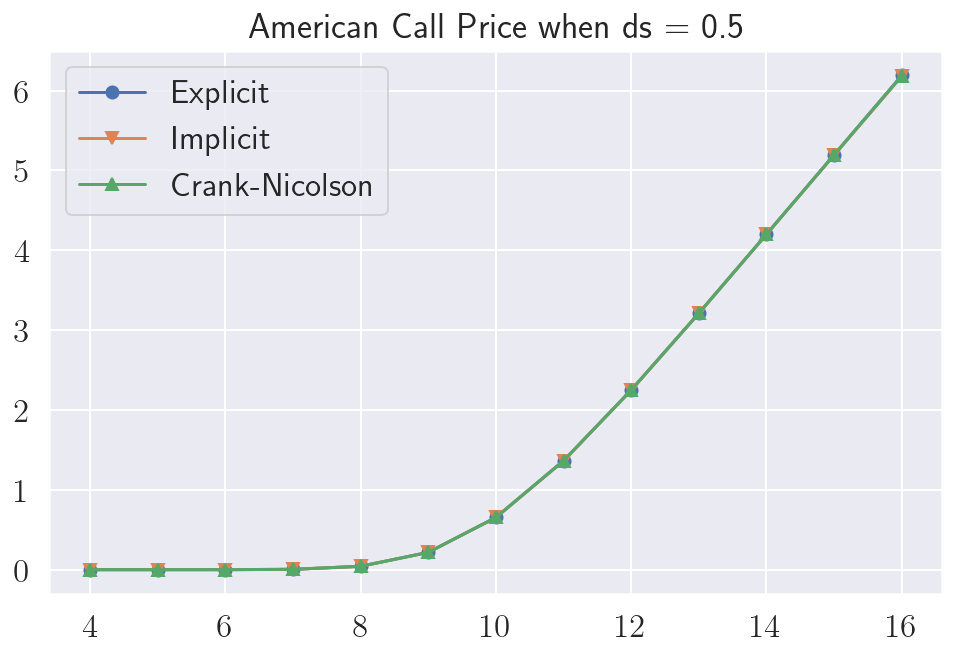

In [29]:
plt.figure(figsize=(8,5))

plt.plot(S0,Ca_ds1,marker='o')
plt.plot(S0,Cb_ds1,marker='v')
plt.plot(S0,Cc_ds1,marker='^')
 
plt.title('American Call Price when ds = 0.5')
plt.legend(['Explicit','Implicit','Crank-Nicolson'])

plt.show()

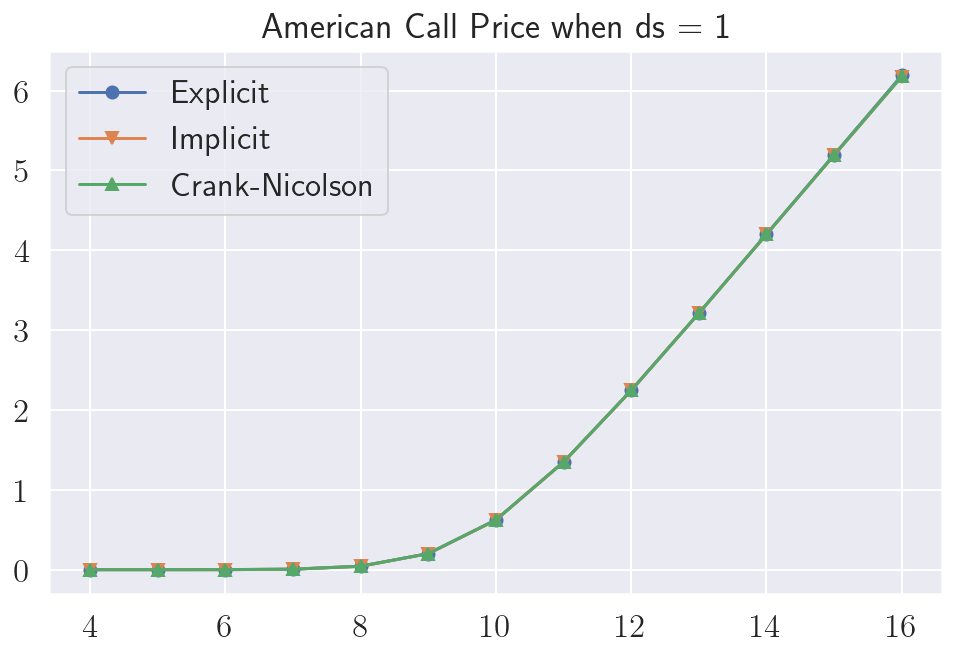

In [32]:
plt.figure(figsize=(8,5))

plt.plot(S0,Ca_ds2,marker='o')
plt.plot(S0,Cb_ds2,marker='v')
plt.plot(S0,Cc_ds2,marker='^')
 
plt.title('American Call Price when ds = 1')
plt.legend(['Explicit','Implicit','Crank-Nicolson'])

plt.show()

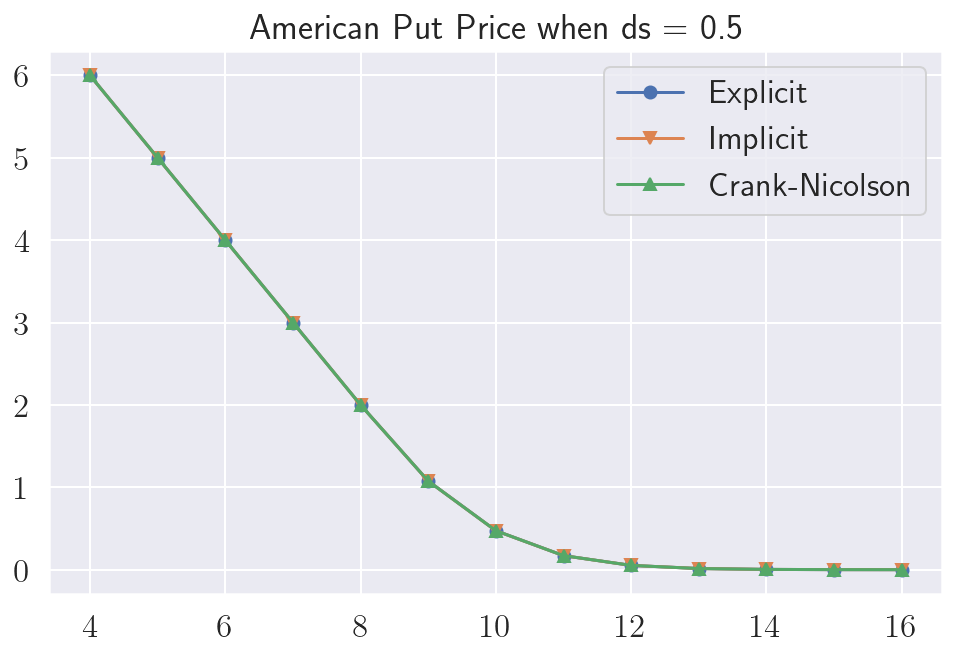

In [33]:
plt.figure(figsize=(8,5))

plt.plot(S0,Pa_ds1,marker='o')
plt.plot(S0,Pb_ds1,marker='v')
plt.plot(S0,Pc_ds1,marker='^')
 
plt.title('American Put Price when ds = 0.5')
plt.legend(['Explicit','Implicit','Crank-Nicolson'])

plt.show()

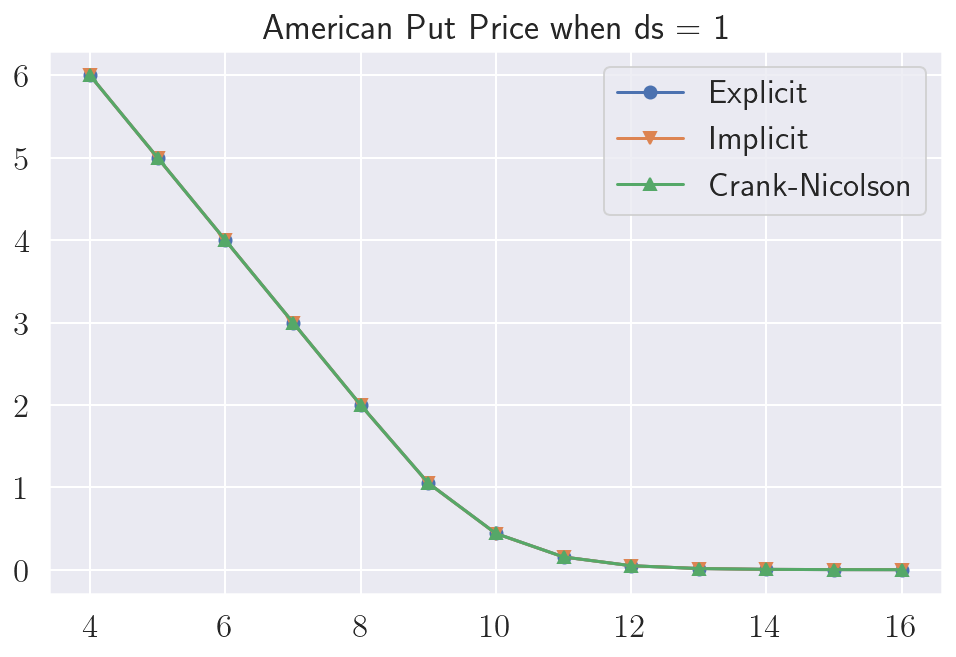

In [34]:
plt.figure(figsize=(8,5))

plt.plot(S0,Pa_ds2,marker='o')
plt.plot(S0,Pb_ds2,marker='v')
plt.plot(S0,Pc_ds2,marker='^')
 
plt.title('American Put Price when ds = 1')
plt.legend(['Explicit','Implicit','Crank-Nicolson'])

plt.show()